In [59]:
import warnings
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt
plt.rc('font',family='AppleGothic')
import pandas as pd
import seaborn as sns

In [60]:
gongduck_df=pd.read_csv('data/final_data/gongduck_congest.csv',index_col=0)
sunleang_df=pd.read_csv('data/final_data/sunleang_congest.csv',index_col=0)
sinlim_df=pd.read_csv('data/final_data/sinlim_congest.csv',index_col=0)

In [61]:
gongduck_df['congestionTrain']=gongduck_df['congestionTrain'].apply(lambda x : x if x != 0 else None)
gongduck_df['time_set'] = gongduck_df['dow'] + \
                          gongduck_df['hh'].apply(lambda x:str(x).zfill(2)) + \
                          gongduck_df['mm'].apply(lambda x:str(x).zfill(2))

In [62]:
tmp=pd.DataFrame(gongduck_df.groupby(['time_set','up_down'])['congestionTrain'].mean()).reset_index()

In [76]:
tmp['time_check']=tmp['time_set'].apply(lambda x: x[3:4])
tmp['day_check']=tmp['time_set'].apply(lambda x: x[:3])

In [77]:
tmp[tmp['time_check']=='0']

,time_set,up_down,congestionTrain,time_check,day_check
0,FRI0700,0,12.5,0,FRI
1,FRI0700,1,24.5,0,FRI
2,FRI0710,0,16.5,0,FRI
3,FRI0710,1,33.0,0,FRI
4,FRI0720,0,22.5,0,FRI
...,...,...,...,...,...
367,WED0930,1,27.5,0,WED
368,WED0940,0,32.0,0,WED
369,WED0940,1,30.0,0,WED
370,WED0950,0,27.0,0,WED


In [67]:
using=[i for i in tmp['time_set'] if i.startswith('MON1')]
tmp_1=tmp[tmp['time_set'].isin(using)]
tmp_1['time_set']=tmp_1['time_set'].apply(lambda x: x.replace('MON',''))
tmp_1['상행_하행']=tmp_1['up_down'].map({0:'상행선',1:'하행선'})

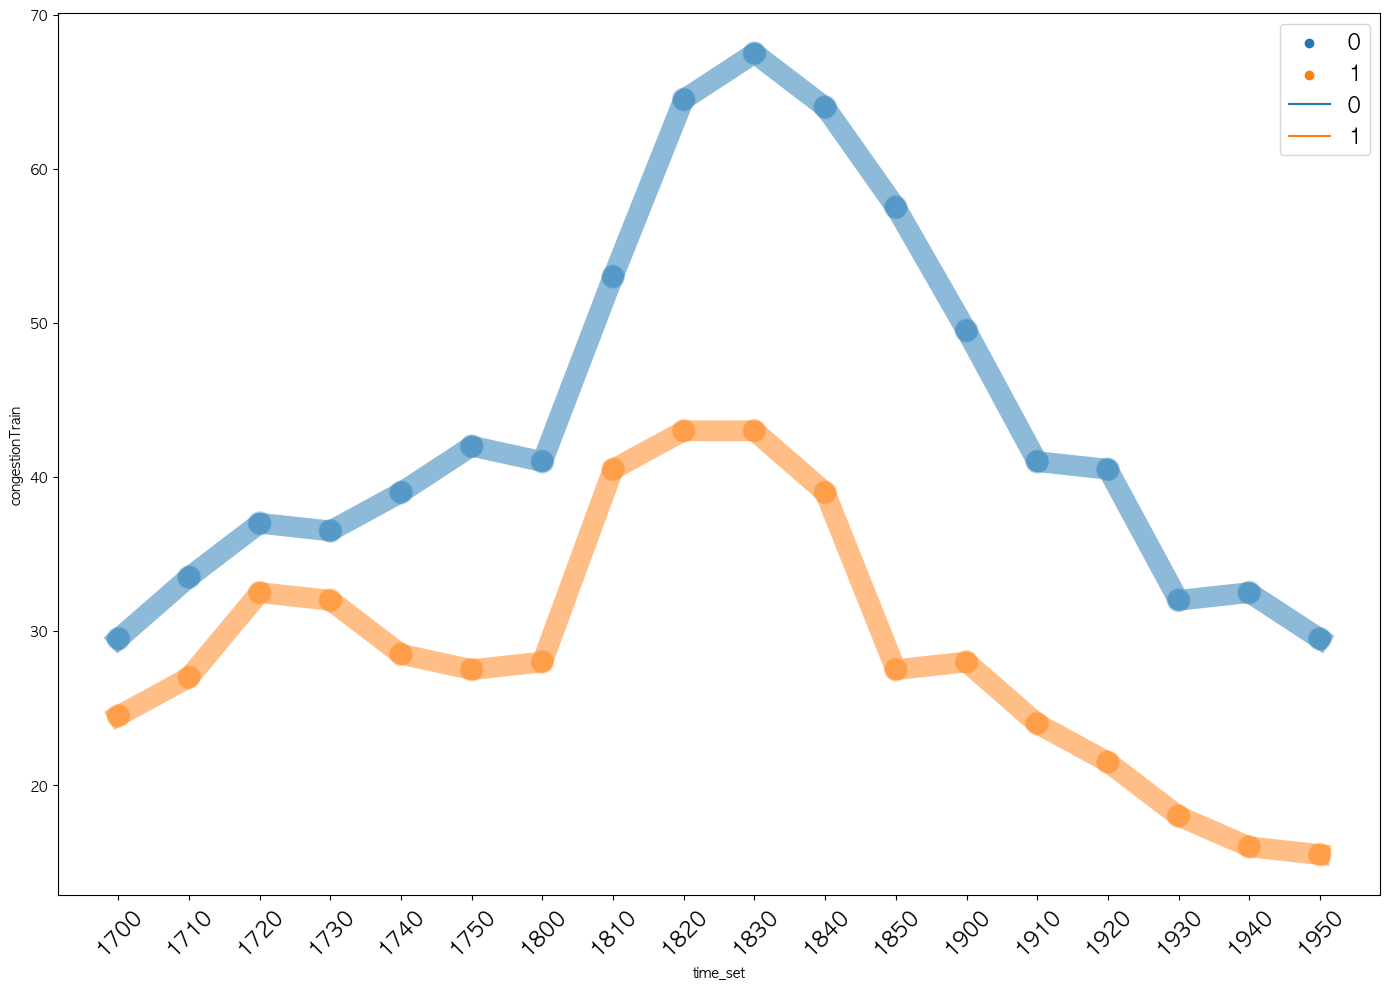

In [68]:
plt.figure(figsize=(14,10))
sns.scatterplot(data=tmp_1,
            x='time_set',
            y='congestionTrain',
            hue='up_down',
            s=300,
            alpha=0.5)
sns.lineplot(data=tmp_1,
            x='time_set',
            y='congestionTrain',
            hue='up_down',
            lw=15,
            alpha=0.5
            )
plt.xticks(rotation=45,fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()
plt.show()